<a href="https://colab.research.google.com/github/shubha07m/vision-language-modeling/blob/main/CNN_based_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Extracting feature from an input image and sample similarity testing

In [26]:
# Importing required libraries
import torch
from torchvision import models
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
import io
import os
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# setting up google drive
from google.colab import drive
drive.mount('/content/drive')
image_path = '/content/drive/MyDrive/sample_images/type_1'

Mounted at /content/drive


In [44]:
# Initializing few model to use for image embedding

model1 = models.mobilenet_v3_small(weights='IMAGENET1K_V1')

model2 = models.resnet50(weights='IMAGENET1K_V1')

model3 = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

model4 = models.convnext_tiny(weights='IMAGENET1K_V1')

model_vit = models.vit_b_16(weights='IMAGENET1K_V1')

In [36]:
# Function for creating image embedding model
def get_image_embedder(model):
    # Remove the last classification layer
    layers = list(model.children())[:-1]

    # Define the embedder model
    embed_model = nn.Sequential(*layers)

    # Set model to evaluation mode
    embed_model.eval()

    return embed_model

In [37]:
def images_to_embeddings(folder_path, model):
    embeddings_list = []

    # Define the transformation
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    # Loop through all files in the folder
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)

        # Ensure it's a file and an image
        if os.path.isfile(image_path) and image_file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp')):
            image = Image.open(image_path)

            # Transform the PIL image to PyTorch tensor
            transformed_image = transform(image)

            # Convert to batches (add batch dimension)
            image_batch = transformed_image.unsqueeze(0)

            # Get embedding without calculating gradients
            with torch.no_grad():
                embedding = model(image_batch)

            # Add embedding to the list
            embeddings_list.append(embedding.numpy())

    # Stack all embeddings along the first axis (batch axis)
    stacked_embeddings = np.vstack(embeddings_list)

    return stacked_embeddings

In [6]:
embed_model = get_image_embedder(model1)

In [7]:
embeddings = images_to_embeddings(image_path, embed_model)

In [8]:
embeddings[1].shape

(576, 1, 1)

In [9]:
em1 = embeddings[0].flatten().reshape(1,-1)
em2 = embeddings[1].flatten().reshape(1,-1)

In [10]:
# calculating sample cosine similarity

similarity = cosine_similarity(em1, em2)
print(type(similarity))
cosine_sim = (similarity.tolist())[0][0]
print(type(cosine_sim))
print(cosine_sim)


<class 'numpy.ndarray'>
<class 'float'>
0.9221574068069458


# Similarity testing on small sample dataset with multiple pre-trained CNNs

In [11]:
# Initializing dataset path
dataset_path = '/content/drive/MyDrive/sample_images/'
similar_data = os.path.join(dataset_path, 'type_1')
different_data = os.path.join(dataset_path, 'type_2')

In [18]:
def cosine_distro(similar = 1, model=model1):

  embed_model = get_image_embedder(model)
  sim_distro = []
  if similar:
    image_path = similar_data

    embeddings = images_to_embeddings(image_path, embed_model)


    for i in range(len(embeddings)):
      for j in range(len(embeddings)):
        em1 = embeddings[i].flatten().reshape(1,-1)
        em2 = embeddings[j].flatten().reshape(1,-1)
        similarity = cosine_similarity(em1, em2)
        cosine_sim = (similarity.tolist())[0][0]
        sim_distro.append(cosine_sim)
    return sim_distro

  else:
    image_path_1 = similar_data
    image_path_2 = different_data

    embeddings_1 = images_to_embeddings(image_path_1, embed_model)
    embeddings_2 = images_to_embeddings(image_path_2, embed_model)


    for i in range(len(embeddings_1)):
      for j in range(len(embeddings_2)):
        em1 = embeddings_1[i].flatten().reshape(1,-1)
        em2 = embeddings_2[j].flatten().reshape(1,-1)
        similarity = cosine_similarity(em1, em2)
        cosine_sim = (similarity.tolist())[0][0]
        sim_distro.append(cosine_sim)
    return sim_distro

In [38]:
# image distro check with mobilenetv3 small
same_distro_mobilenetv3 =  cosine_distro(1,model1)
diff_distro_mobilenetv3 = cosine_distro(0,model1)

In [39]:
# image distro check with resnet50
same_distro_resnet50 = cosine_distro(1, model2)
diff_distro_resnet50 = cosine_distro(0, model2)

In [40]:
# image distro check with efficientnet
same_distro_efficientnet = cosine_distro(1, model3)
diff_distro_efficientnet = cosine_distro(0, model3)

In [42]:
# image distro check with convnext
same_distro_convnext = cosine_distro(1, model4)
diff_distro_convnext = cosine_distro(0, model4)

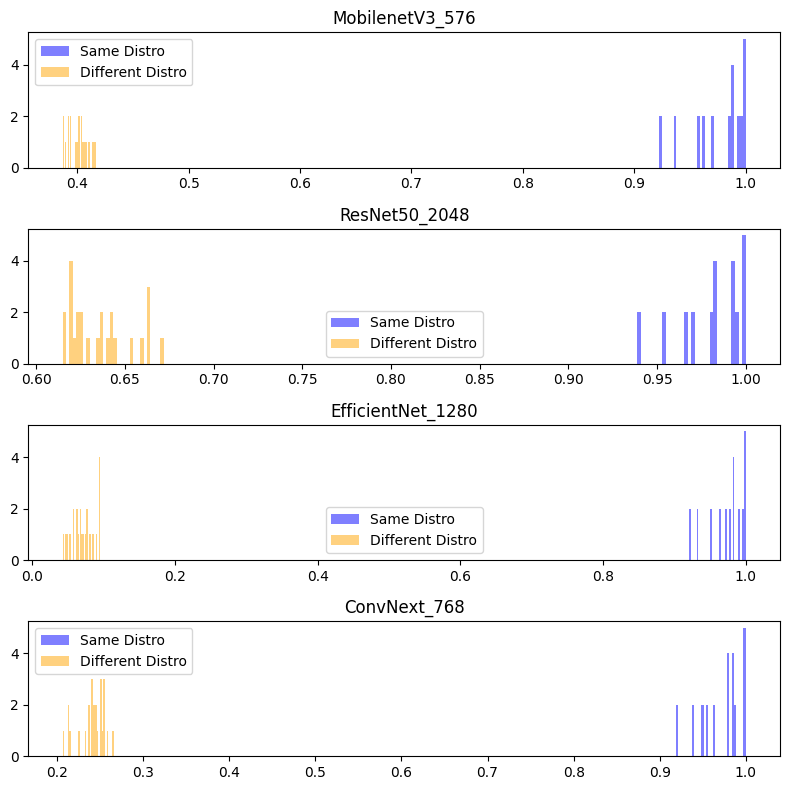

In [46]:
# Grouping them into pairs
groups = [
    (same_distro_mobilenetv3, diff_distro_mobilenetv3, 'MobilenetV3_576'),
    (same_distro_resnet50, diff_distro_resnet50, 'ResNet50_2048'),
    (same_distro_efficientnet, diff_distro_efficientnet, 'EfficientNet_1280'),
    (same_distro_convnext, diff_distro_convnext, 'ConvNext_768')
]

# Create subplots
fig, axes = plt.subplots(len(groups), 1, figsize=(8, 8))

# Plot histograms for each group in a subplot
for i, (same_distro, diff_distro, title) in enumerate(groups):
    axes[i].hist(same_distro, bins=30, alpha=0.5, label='Same Distro', color='blue')
    axes[i].hist(diff_distro, bins=30, alpha=0.5, label='Different Distro', color='orange')
    axes[i].set_title(title)
    axes[i].legend()

# Display the plot
plt.tight_layout()
plt.show()